# Case Study: Cat vs. Dog Image Classification

![ss](screenshot.png)


### Proje Açıklaması:
Bu proje kapsamında, bir görüntünün kedi mi yoksa köpek mi olduğunu sınıflandırmak için bir derin öğrenme modeli geliştirecektir.

### Veri Kümesi:
"Cat" ve "Dog" sınıflarına ait veri kümesi [buradan](https://www.kaggle.com/c/dogs-vs-cats/data) indirilmiştir.

[Proje Github Reposu](https://github.com/kntvrl/cat_dog_classification_with_keras_funktional_api/)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import gradio as gr
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.api.preprocessing.image import load_img, img_to_array
from keras.api.preprocessing import image
from keras.src.saving import load_model
from keras.src.models import Model
from keras.src.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Layer
from keras.src.callbacks import TensorBoard, ModelCheckpoint
from keras.src.optimizers import Adam
from keras import saving
%load_ext tensorboard

c:\Users\iskorpittt\Desktop\MY_DATA_SCIENCE\PROJECTS\kodlasam_cat_dog_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Veri Keşfi ve Ön İşleme

### 1.1 Veri kümesinin yüklenip ve görselleştirmesi

In [3]:
train_dir = 'train'  
validation_dir = 'validation'
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [4]:

def show_images(images, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(images):
        img = load_img(img_path, target_size=(150, 150))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i + 1}')
        plt.axis('off')
    plt.show()

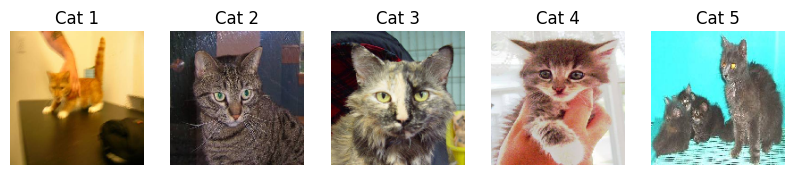

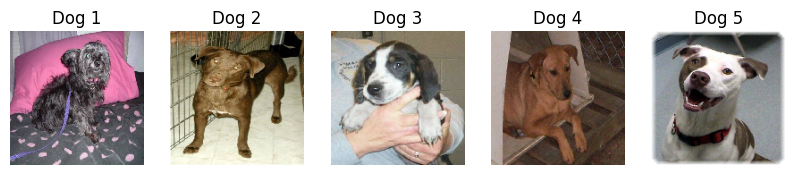

In [5]:
sample_cats_train = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)[:5]]
sample_dogs_train = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)[:5]]

show_images(sample_cats_train, 'Cat')
show_images(sample_dogs_train, 'Dog')

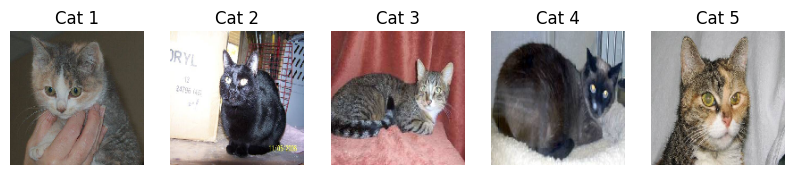

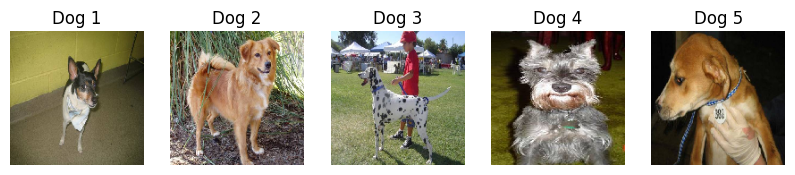

In [48]:
sample_cats_validation = [os.path.join(validation_cats_dir, fname) for fname in os.listdir(validation_cats_dir)[:5]]
sample_dogs_validation = [os.path.join(validation_dogs_dir, fname) for fname in os.listdir(validation_dogs_dir)[:5]]

show_images(sample_cats_validation, 'Cat')
show_images(sample_dogs_validation, 'Dog')

### 1.2 Görüntülerin boyutunu, renk kanallarını ve dağılımlarını analiz edilmesi

Train ve Validation klasörlerindeki cat ve dog sınıflarının dağılımı

In [49]:
data_info = pd.DataFrame({
    "Category": ["Train Cats", "Train Dogs", "Validation Cats", "Validation Dogs"],
    "Count": [len(os.listdir(train_cats_dir)), len(os.listdir(train_dogs_dir)), len(os.listdir(validation_cats_dir)), len(os.listdir(validation_dogs_dir))]
})
data_info.head()

Category  Count
0       Train Cats    501
1       Train Dogs    501
2  Validation Cats    102
3  Validation Dogs    101

<Axes: xlabel='Category', ylabel='Count'>

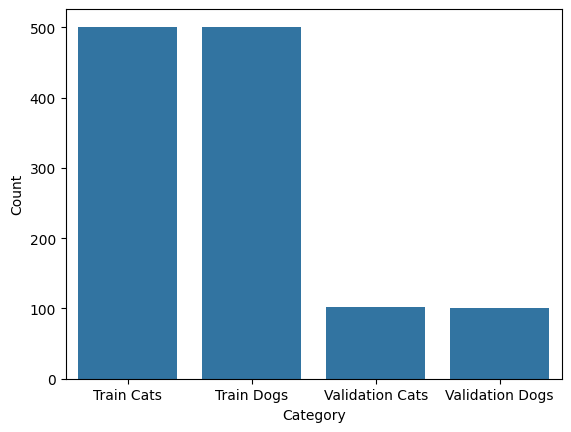

In [50]:
sns.barplot(data=data_info, x ="Category", y= "Count")

Boyut ve renk kanalları analizi

In [51]:
def compute_image_statistics(directory):
    widths = []
    heights = []
    channel_counts = []

    for file_name in os.listdir(directory):
        image_path = os.path.join(directory, file_name)
        image = load_img(image_path)
        image_array = img_to_array(image)
        
        width, height = image.size
        widths.append(width)
        heights.append(height)
        channel_counts.append(image_array.shape[2]) 

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    avg_channels = np.mean(channel_counts)

    return avg_width, avg_height, avg_channels

In [52]:
avg_width_train_cats, avg_height_train_cats, avg_channels_train_cats = compute_image_statistics(train_cats_dir)
avg_width_train_dogs, avg_height_train_dogs, avg_channels_train_dogs = compute_image_statistics(train_dogs_dir)
avg_width_val_cats, avg_height_val_cats, avg_channels_val_cats = compute_image_statistics(validation_cats_dir)
avg_width_val_dogs, avg_height_val_dogs, avg_channels_val_dogs = compute_image_statistics(validation_dogs_dir)


print(f"Train Cats - Avg Width: {avg_width_train_cats:.2f}, Avg Height: {avg_height_train_cats:.2f}, Avg Channels: {avg_channels_train_cats:.2f}")
print(f"Train Dogs - Avg Width: {avg_width_train_dogs:.2f}, Avg Height: {avg_height_train_dogs:.2f}, Avg Channels: {avg_channels_train_dogs:.2f}")
print(f"Validation Cats - Avg Width: {avg_width_val_cats:.2f}, Avg Height: {avg_height_val_cats:.2f}, Avg Channels: {avg_channels_val_cats:.2f}")
print(f"Validation Dogs - Avg Width: {avg_width_val_dogs:.2f}, Avg Height: {avg_height_val_dogs:.2f}, Avg Channels: {avg_channels_val_dogs:.2f}")

Train Cats - Avg Width: 408.44, Avg Height: 354.39, Avg Channels: 3.00
Train Dogs - Avg Width: 397.61, Avg Height: 362.79, Avg Channels: 3.00
Validation Cats - Avg Width: 399.48, Avg Height: 361.60, Avg Channels: 3.00
Validation Dogs - Avg Width: 432.56, Avg Height: 375.86, Avg Channels: 3.00


Örnek bir resmin renk kanallarının görselleştirilmesi

In [53]:

image_path = "train/cat/cat.38.jpg"  
image = Image.open(image_path)

r, g, b = image.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)


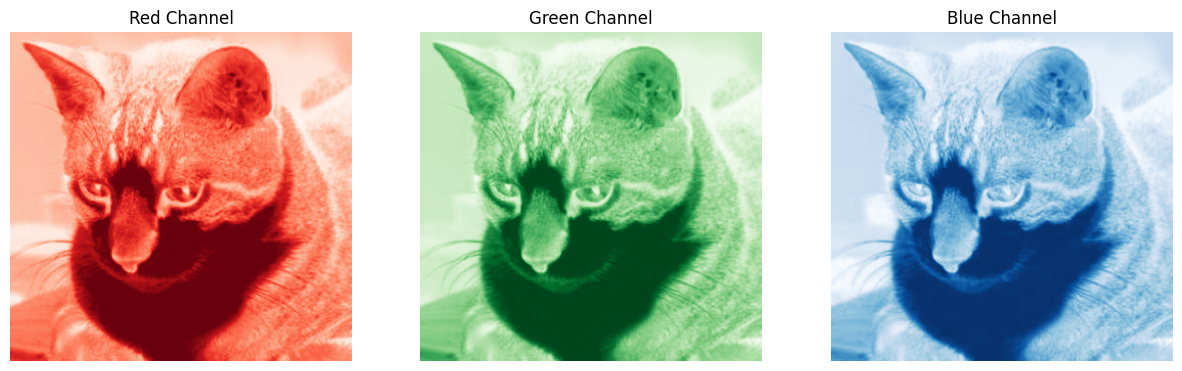

In [54]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(r_array, cmap="Reds")
axes[0].set_title("Red Channel")
axes[0].axis("off")

axes[1].imshow(g_array, cmap="Greens")
axes[1].set_title("Green Channel")
axes[1].axis("off")

axes[2].imshow(b_array, cmap="Blues")
axes[2].set_title("Blue Channel")
axes[2].axis("off")

plt.show()


### 1.3 Görüntüler üzerinde ön işleme adımlarını gerçekleştirilmesi (örneğin, yeniden boyutlandırma, normalleştirme).

Burada normalizasyon resizing ve data augmentation işlemleri yapılmıştır. Kedi 0 , köpek 1 olarak etiketlenmiştir.

In [55]:

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalization (0-255 to 0-1 range)
    rotation_range=40,        # random rotation 
    width_shift_range=0.2,    # random width shift
    height_shift_range=0.2,   # random height shift
    shear_range=0.2,          # random shear
    zoom_range=0.2,           # random zoom
    horizontal_flip=True,     
    fill_mode='nearest'       # fill method
)


val_datagen = ImageDataGenerator(rescale=1./255)  # only normalization for validation set

# load train images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # resizing
    batch_size=32,
    class_mode='binary'      # binary classification (cat, dog)
)

# load validation images
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary'   
)

class_indices = train_generator.class_indices
print("Class labels:", class_indices)

Found 1002 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Class labels: {'cat': 0, 'dog': 1}


Dönüşüm kontrolü

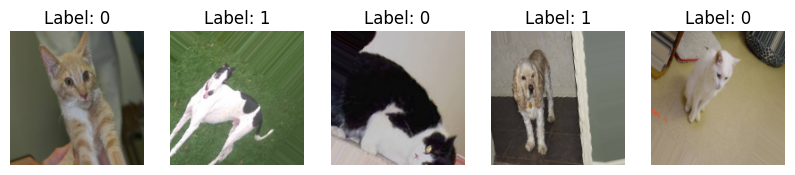

In [56]:

batch = next(train_generator)
images, labels = batch

# first 5 images
num_images = min(5, len(images))  # check batch size

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i]) 
    plt.title(f"Label: {int(labels[i])}")  
    plt.axis('off') 
plt.show()

## 2. Model Seçimi ve Eğitimi

Burada aşağıdaki görevler yerine getirilmiştir.

- Derin öğrenme modelinin seçilmesi
- Seçtilen modeli eğitmek için eğitim ve doğrulama veri setlerini kullanılması. Overfitting'i önlemek için dropout yada regularizasyon uygulanması
- Gerekli hiperparametrelerin belirlenmesi.


Derin öğrenme mimarisi olarak CNN (Convolutional Neural Network) kullanılacaktır. Burada resnet yada efficientnet_b0 gibi modellerin son katmanı eğitilerek transfer learning metodları da uygulanabilir. Bu case studyde sinir CNN model baştan oluşturulmuştur.

### Açıklamalar

**Class yapısı ile keras functional api kullanımı**
- Functional API, model yapılandırmasını daha detaylı ve esnek bir şekilde özelleştirme imkanı sunar. Bu, özellikle daha karmaşık ve özelleştirilmiş ağ yapıları oluştururken faydalıdır.
  
- Daha karmaşık modeller, çoklu giriş ve çıkış, paylaşılan katmanlar veya atlamalı bağlantılar gibi özellikler gerektirebilir. Functional API, bu tür yapıları yönetmek için gerekli esnekliği sağlar.
  
- Model tasarımında Functional API'yi kullanmak, daha karmaşık yapılarla çalışma deneyimi kazanmayı sağlar. Bu, gelecekte daha ileri seviye ağ yapıları geliştirirken el alışkanlığı kazanmayı sağlar. Bu şekilde, Sequential API ile sınırlı kalmadan daha geniş bir model yelpazesine hakim olunabilir.

**Model Yapısı**
- CNN (Convolutional Neural Network) yapısında genellikle birkaç evrişim (convolutional) katmanı kullanılır. Her bir Conv2D katmanı, görüntülerden daha karmaşık ve soyut özellikler çıkartır. İlk katmanlar daha temel özellikleri (kenar, köşe vb.) öğrenirken, daha derin katmanlar daha karmaşık ve yüksek seviyeli özellikleri öğrenir. Bu nedenle modelde 3 evrişim katmanı kullanarak, modelin daha zengin özellikler öğrenmesi hedeflenmiştir.
- Derin bir ağ, daha karmaşık ilişkileri öğrenebilir, ancak burada veri sayımız az olduğundan aşırı derinlik modelin eğitimini zorlaştırabilir ve overfitting riskini artırabilir. Bu dengeyi kurmak için  3 evrişim katmanı uygulanmıştır.

**Katmanların Açıklamaları**

- Conv2D: Evrişim katmanları, görüntülerdeki uzaysal ilişkileri öğrenir. 32, 64 ve 128 filtreler kullanarak her bir evrişim katmanının farklı seviyelerde özellikler öğrenmesi sağlanır.

- BatchNormalization: Bu, her bir batch'teki aktivasyonların normalizasyonunu sağlar. Bu, modelin eğitim sürecini stabilize eder ve öğrenme hızını artırabilir.

- MaxPooling2D: Bu katman, özellik haritalarının boyutlarını küçültür ve en önemli özellikleri korur. Modelin hesaplama yükünü azaltır ve daha yüksek seviyeli özelliklerin öğrenilmesine yardımcı olur.
  
- Dropout: Aşırı öğrenmeyi (overfitting) önlemek için kullanılır. Eğitim sırasında rastgele olarak bazı nöronları devre dışı bırakır, böylece modelin belirli nöronlara aşırı bağımlı olmasını engeller.
  
- GlobalAveragePooling2D: 2D özellik haritalarını her kanalın ortalamalarını alarak 1D vektörlere dönüştürür, parametre sayısını azaltılıp ve modelin aşırı öğrenmesini (overfitting) önleyebilir.
  
- Dense: Fully connected katmanlar, nöronlar arasındaki tüm bağlantıları kullanarak, yüksek seviyeli özellikleri öğrenir. Son katman sigmoid aktivasyon fonksiyonu ile, iki sınıflı (binary- cat, dog) sınıflandırma yapılır.

**Hiperparametreler ve Seçimleri**

- Filtre sayılarını artırarak derinleştirilmiş bir model yapısının kullanılması genellikle iyi bir pratik olarak kabul edildiğinden  3 katman için 32, 64, 128 seçilmiştir.
  
- Dropout oranı, modelin eğitim sırasında hangi oranda nöronların devre dışı bırakılacağını belirler. Genellikle 0.25 ile 0.5 arasındaki değerler kullanılır. Daha yüksek değerler, modelin overfitting riskini azaltabilir ancak aşırı yüksek dropout oranları modelin performansını olumsuz etkileyebilir.

- Epoch sayısı, Eğitim sırasında modelin kaç kez eğitim verileri üzerinde çalıştırılacağını belirler. Deneme yanılma yolu ile ayarlanmıştır.

**Model Eğitimi ve İzleme**

- Modelcheckpoint, modelin her epoch'ta belirli bir dosya adına kaydedilmesini sağlar. save_best_only=True ile sadece en iyi performansa sahip modelin kaydedilmesi hedeflenmiştir.

- Tensorboard, Eğitim sırasında modelin performansını izlemek için kullanılır. TensorBoard callbacki eğitim ve doğrulama kayıplarını doğrulukları ve diğer metrikleri görselleştirir ve eğitim sürecinde modelin ne kadar iyi performans gösterdiğini ve hiperparametre ayarlarının etkilerini görmenizi sağlar.


**Daha moduler bir yapı için konvolusyon blocklarının oluşturulması**

In [57]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dropout_rate, input_shape=None):
        super(ConvBlock, self).__init__()
        self.conv = Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape)
        self.bn = BatchNormalization()
        self.pool = MaxPooling2D((2, 2))
        self.drop = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.pool(x)
        x = self.drop(x, training=training)
        return x

class ConvBlock1(ConvBlock):
    def __init__(self, input_shape=None):
        super(ConvBlock1, self).__init__(32, (3, 3), dropout_rate=0.25, input_shape=input_shape)

class ConvBlock2(ConvBlock):
    def __init__(self):
        super(ConvBlock2, self).__init__(64, (3, 3), dropout_rate=0.25)

class ConvBlock3(ConvBlock):
    def __init__(self):
        super(ConvBlock3, self).__init__(128, (3, 3), dropout_rate=0.25)

In [58]:

@saving.register_keras_serializable()
class CustomCNN(Model):
    def __init__(self, input_shape=(150, 150, 3), num_classes=1, name="custom_cnn", **kwargs):
        super(CustomCNN, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes

        self.conv_block1 = ConvBlock1(input_shape=input_shape)
        self.conv_block2 = ConvBlock2()
        self.conv_block3 = ConvBlock3()

        self.global_avg_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.drop4 = Dropout(0.5)
        self.fc2 = Dense(num_classes, activation='sigmoid')  # Binary classification

    def call(self, inputs, training=False):
        x = self.conv_block1(inputs, training=training)
        x = self.conv_block2(x, training=training)
        x = self.conv_block3(x, training=training)
        
        x = self.global_avg_pool(x) 
        x = self.fc1(x)
        x = self.drop4(x, training=training)
        outputs = self.fc2(x)
        
        return outputs

    def get_config(self):
        config = super(CustomCNN, self).get_config()
        config.update({
            "input_shape": (150, 150, 3),
            "num_classes": self.num_classes
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def train(self, train_dir, val_dir, batch_size=32, epochs=10):
        # Data preprocessing
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        validation_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary'
        )
        
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary' 
        )
        
        # ModelCheckpoint callback
        checkpoint_callback = ModelCheckpoint(
            filepath='models/model_checkpoint_{epoch:02d}.keras',  
            monitor='val_loss',
            save_best_only=True,  
            save_weights_only=False,
            mode='min',
            verbose=1
        )
        
        # TensorBoard callback
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        # Define learning rate
        optimizer = Adam(learning_rate=0.001)
        
        self.compile(optimizer=optimizer,
                     loss='binary_crossentropy',  # Binary classification loss function
                     metrics=['accuracy'])
        
        history = self.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[checkpoint_callback, tensorboard_callback],
        )
        
        return history

In [59]:
model = CustomCNN(input_shape=(150, 150, 3), num_classes=1)

c:\Users\iskorpittt\Desktop\MY_DATA_SCIENCE\PROJECTS\kodlasam_cat_dog_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.train(train_dir=train_dir, val_dir=validation_dir, batch_size=32, epochs=60)

Found 1002 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Epoch 1/60


c:\Users\iskorpittt\Desktop\MY_DATA_SCIENCE\PROJECTS\kodlasam_cat_dog_project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.5367 - loss: 0.7769
Epoch 1: val_loss improved from inf to 0.68880, saving model to models/model_checkpoint_01.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 850ms/step - accuracy: 0.5378 - loss: 0.7752 - val_accuracy: 0.5025 - val_loss: 0.6888
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6242 - loss: 0.6465
Epoch 2: val_loss did not improve from 0.68880
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6244 - loss: 0.6469 - val_accuracy: 0.5025 - val_loss: 0.7320
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.6031 - loss: 0.6543
Epoch 3: val_loss did not improve from 0.68880
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6028 - loss: 0.6549 - val_accuracy: 0.5025 - val_loss: 0.8047
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.5972 - loss: 0.6636
Epoch 4: val_loss did not improve from 0.68880
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 989ms/step - accuracy: 0.5967 - loss: 0.6639 - val_ac

In [62]:
model.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block1_3 (ConvBlock1)      │ ?                      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_3 (ConvBlock2)      │ ?                      │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_3 (ConvBlock3)      │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,221 (1.84 MB)

 Trainable params: 160,257 (626.00 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 320,516 (1.22 MB)

Globalmaxpooling sayesinde parametre sayısı 19 milyondan 481221'e inmiştir.
Model seçimi için 39 numaralı epochda eğitilen model semilmiştir(accuracy: 0.7543 - loss: 0.4873 - val_accuracy: 0.7586 - val_loss: 0.4863)

Eğitim ve Validaston accuracy ve loss değerlerinin tensorboard ile görselleştirilmesi.

In [34]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 8212), started 0:00:22 ago. (Use '!kill 8212' to kill it.)

Eğitim ve validasyon accuracy ve loss değerlerini görselleştirdiğimizde 39. numaralı epochdan sonra bozulmanın başladığı gözlemlenebilmektedir.

## 3. Model Değerlendirme

Burada aşağıdaki görevler yerine getirilmiştir.

- Eğitim tamamlandıktan sonra, modelin test seti üzerinde performansını değerlendirilmesi.
  
- Sınıflandırma doğruluğu, confusion matrix, accuracy, precision ve recall gibi metrikleri kullanarak modelin performansının analiz edilmesi.
  
- Modelin yanlış sınıflandırdığı örnekleri görselleştirerek hataların incelenmesi.


**Test verileri uygun formata getirilip tahmin yapıldıktan sonra performans metrikleri hesaplanmıştır.**

En iyi model seçilmiştir.

In [61]:
model = load_model("models/model_checkpoint_39.keras")

prediction için test resimleri uygun formata getirilmiştir.

Found 203 images belonging to 2 classes.


c:\Users\iskorpittt\Desktop\MY_DATA_SCIENCE\PROJECTS\kodlasam_cat_dog_project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step
Accuracy: 0.7635467980295566
Precision: 0.7387387387387387
Recall: 0.8118811881188119


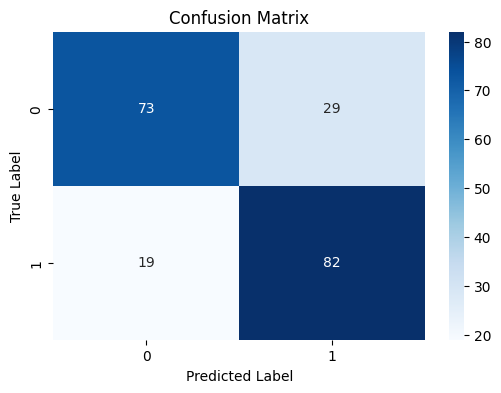

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       102
           1       0.74      0.81      0.77       101

    accuracy                           0.76       203
   macro avg       0.77      0.76      0.76       203
weighted avg       0.77      0.76      0.76       203



In [63]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)

predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)

true_classes = test_generator.classes

# Performance mtrics
print("Accuracy:", accuracy_score(true_classes, predicted_classes))
print("Precision:", precision_score(true_classes, predicted_classes))
print("Recall:", recall_score(true_classes, predicted_classes))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# classification report
print(classification_report(true_classes, predicted_classes))

**Performans Metrikleri**
Bu sonuçlardan hesaplanan metrikler:

- Accuracy: Genel olarak modelin ne kadar doğru tahminde bulunduğunu gösterir.
- Precision: Pozitif sınıfın (köpek) model tarafından doğru tahmin edilme oranı.
- Recall: Gerçek pozitif sınıflardan model tarafından doğru tahmin edilen oran.
- F1 Score: Precision ve recall harmonik ortalaması.

**Confusion Matrix Analizi**

- True Negative (TN): Modelin doğru bir şekilde kedi olarak sınıflandırdığı kedi örneklerinin sayısı.
- False Negative (FN): Modelin köpek yerine kedi olarak sınıflandırdığı köpek örneklerinin sayısı.
- False Positive (FP): Modelin kedi yerine köpek olarak sınıflandırdığı kedi örneklerinin sayısı.
- True Positive (TP): Modelin doğru bir şekilde köpek olarak sınıflandırdığı köpek örneklerinin sayısı.

- TN = 86 (kedi olarak doğru sınıflandırılmış kedi örnekleri)
- FN = 33 (köpek olarak yanlış sınıflandırılmış kedi örnekleri)
- FP = 16 (kedi olarak yanlış sınıflandırılmış köpek örnekleri)
- TP = 68 (köpek olarak doğru sınıflandırılmış köpek örnekleri)

**Classification Report Analizi**

**Sınıf 0 (Kedi):**

Precision: 0.72
Kedi olarak tahmin edilen örneklerin %72'si gerçekten kedi. Bu, modelin kedileri tanımada ne kadar başarılı olduğunu gösterir.

Recall: 0.84
Gerçekten kedi olan örneklerin %84'ü model tarafından doğru bir şekilde kedi olarak tanınmış. Bu, modelin kedileri bulma yeteneğinin yüksek olduğunu gösterir.

F1-score: 0.78
Kediler için modelin genel performansının iyi olduğunu gösterir.

**Sınıf 1 (Köpek):**

Precision: 0.81
Köpek olarak tahmin edilen örneklerin %81'i gerçekten köpek. Bu, modelin köpekleri tanımada oldukça başarılı olduğunu gösterir.

Recall: 0.67
Gerçekten köpek olan örneklerin %67'si model tarafından doğru bir şekilde köpek olarak tanınmış. Bu, modelin köpekleri bulma yeteneğinin biraz düşük olduğunu gösterir.

F1-score: 0.74
Köpekler için modelin genel performansının yeterli olduğunu gösterir.

**Yanlış sınıflandırılan örneklerin görselleştirilmesi**

Validation sette yanlış sınıflandırılan toplam 49 adet resim vardır

In [64]:
test_generator.reset # right order
df = pd.DataFrame({
    'filename':test_generator.filenames,
    'predict':predicted_classes[:,0],
    'y':test_generator.classes
})
misclassified = df[df['y']!=df['predict']]
print(f'Total misclassified images : {misclassified['y'].count()}')

Total misclassified images : 48


Köpek olarak yanlış sınıflandırılan kedi resimleri

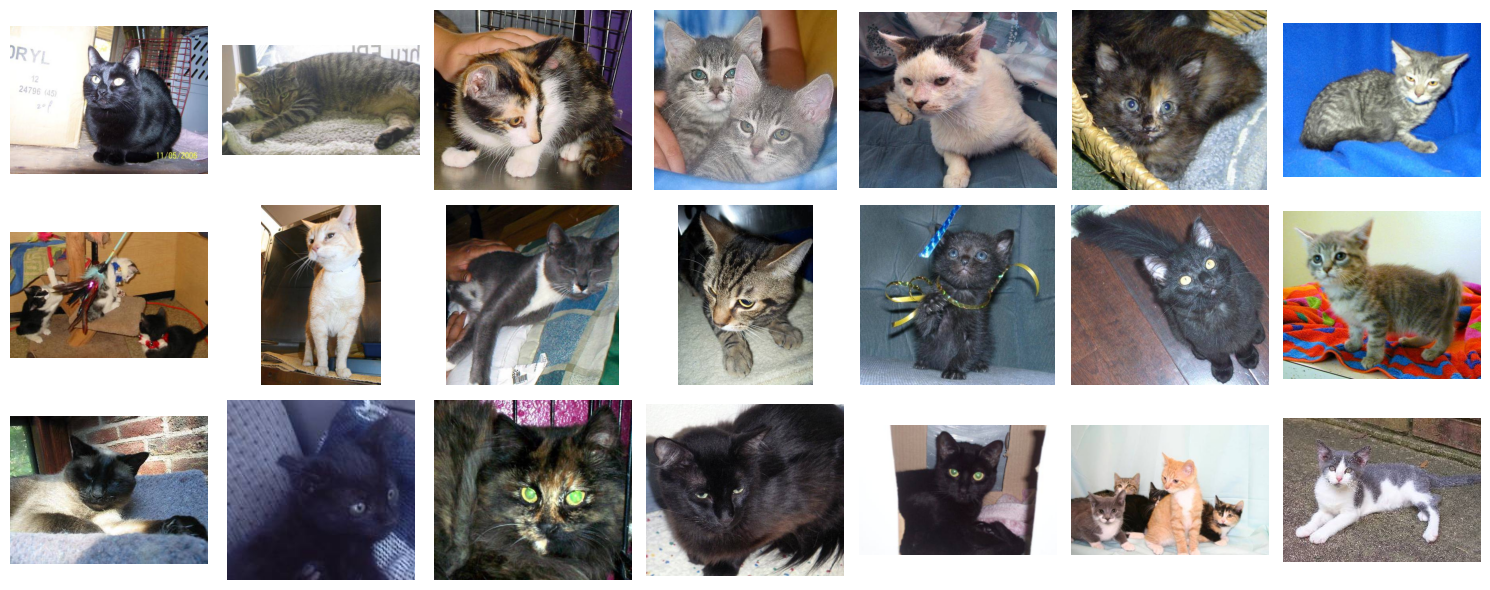

In [72]:
from keras.api.preprocessing import image

cat_as_dog = df['filename'][(df["y"] == 0) & (df["predict"] == 1)]

fig = plt.figure(figsize=(15, 6))
columns = 7
rows = 3
num_images = min(columns * rows, len(cat_as_dog))

for i in range(num_images):
    img_path = os.path.join('validation', cat_as_dog.iloc[i])
    
    if os.path.exists(img_path):
        img = image.load_img(img_path)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
    else:
        print(f"Warning: File not found {img_path}")

plt.tight_layout()
plt.show()

Kedi olarak yanlış sınıflandırılan köpek resimleri

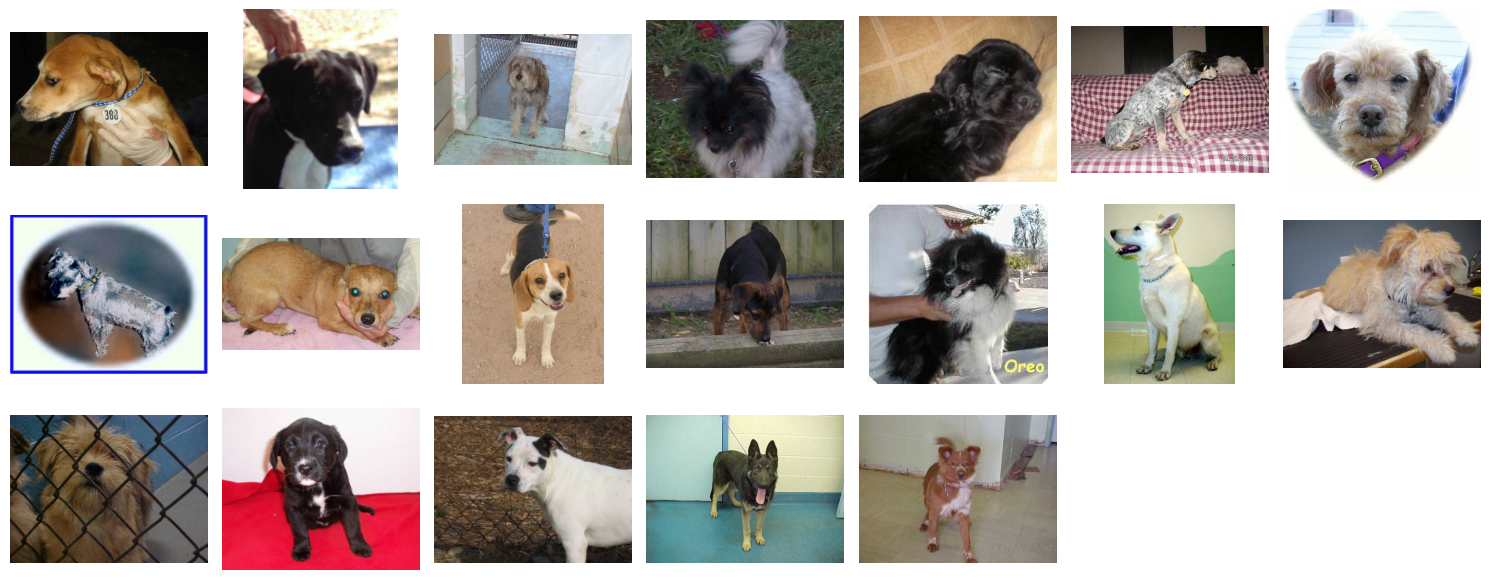

In [73]:
dog_as_cat = df['filename'][(df["y"] == 1) & (df["predict"] == 0)]

fig = plt.figure(figsize=(15, 6))
columns = 7
rows = 3
num_images = min(columns * rows, len(dog_as_cat))

for i in range(num_images):
    img_path = os.path.join('validation', dog_as_cat.iloc[i])
    
    if os.path.exists(img_path):
        img = image.load_img(img_path)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
    else:
        print(f"Warning: File not found {img_path}")

plt.tight_layout()
plt.show()

### TAHMIN

Validasyon setinden manuel olarak resim seçim modelin başarısı denenmiştir.

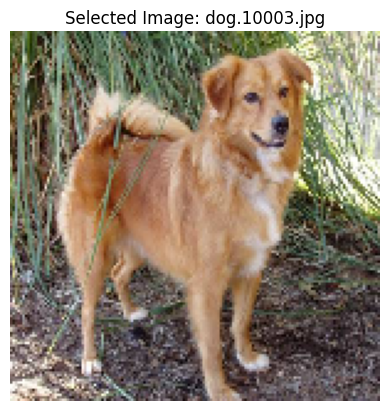

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted Label: Dog (Confidence: 0.51)


In [67]:
selected_image_path = os.path.join(validation_dir, 'dog', 'dog.10003.jpg')
image = load_img(selected_image_path, target_size=(150, 150))
plt.imshow(image)
plt.title(f"Selected Image: {os.path.basename(selected_image_path)}")
plt.axis('off')
plt.show()

image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

single_prediction = model.predict(image_array)

predicted_label = "Dog" if single_prediction > 0.5 else "Cat"
print(f"Predicted Label: {predicted_label} (Confidence: {single_prediction[0][0]:.2f})")

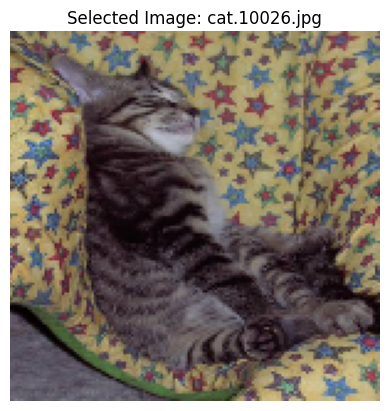

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label: Cat (Confidence: 0.37)


In [68]:
selected_image_path = os.path.join(validation_dir, 'cat', 'cat.10026.jpg')
image = load_img(selected_image_path, target_size=(150, 150))
plt.imshow(image)
plt.title(f"Selected Image: {os.path.basename(selected_image_path)}")
plt.axis('off')
plt.show()

image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

single_prediction = model.predict(image_array)

predicted_label = "Dog" if single_prediction > 0.5 else "Cat"
print(f"Predicted Label: {predicted_label} (Confidence: {single_prediction[0][0]:.2f})")

### WEB UYGULAMASI

Uygulama için gradio kütüphanesi kullanılmıştır. Validasyon setinden ve internetten resimler ile denenmiştir. Kedi ve Köpek sınıflarını yüksek oranda doğru bir şekilde ayırmaktadır.

In [69]:
def predict(image):
 
    image = image.resize((150, 150))  
    image_array = img_to_array(image) / 255.0 
    image_array = np.expand_dims(image_array, axis=0)  # batch dimension
    single_prediction = model.predict(image_array)[0][0]
    predicted_label = "Dog" if single_prediction > 0.5 else "Cat"
    confidence = float(single_prediction) if single_prediction > 0.5 else float(1 - single_prediction)
    return predicted_label, confidence


interface = gr.Interface(
    fn=predict,  
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[gr.Textbox(label="Predicted Label"), gr.Number(label="Confidence")], 
    title="Dog vs Cat Classifier",  # Başlık
    description="Upload an image to classify it as Dog or Cat and see the confidence value." 
)

interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
